# **Colab + PyTorch + OpenCV + Google Drive進行影像分類**
歐尼克斯實境互動工 作室 OmniXRI Jack 2020.12.08整理製作

本範例利用雲端硬體Google Drive儲存資料集及訓練好的模型，主要使用PyTorch進行程式開發，最後搭配OpenCV取得外部影像進行推論。

執行本範例前，請先確認系統已處於GPU開啟模式，選單【編輯】─【筆記本設定】─【硬體加速器】─ GPU。

主要工作如下

*   掛載雲端硬碟到虛擬機
*   複製資料集到虛擬機
*   取得資料集路徑
*   製作PyTorch格式資料集
*   隨機取出批次資料
*   建立卷積神經網路
*   開始訓練模型及權重
*   進行推論











In [1]:
!nvidia-smi # 檢查GPU硬體環境及CUDA版本

Mon Dec  7 21:40:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import tensorflow as tf
import cv2
import sys

print(sys.version) # 檢查Python版本
print(torch.__version__) # 檢查PyTorch版本
print(tf.__version__) # 檢查TensorFlow版本
print(cv2.__version__) # 檢查OpenCV版本

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
1.7.0+cu101
2.3.0
4.1.2


# **掛載雲端硬碟到虛擬機**

In [3]:
# 導入Google Drvie套件包
from google.colab import drive

# 將自己的雲端硬碟掛載到Colab虛擬機上
# 參考資料來源:https://colab.research.google.com/drive/1i41Whco5KIb7EuntKYwTVORAkAwCmlkF
drive.mount('/content/gdrive')

# 點選 Go to this URL in a browser: 後的網址，並複製授權碼(Authorization Code)
# 貼到到下方 Authorization Code 空格位置
# 雲端硬碟成功掛載到Colab虛擬機下 /content/gdriver/MyDrive 
# 點選畫面左方檔案夾圖示亦能看到掛載結果

# 本範例使用的資料集及最後完成訓練的模型及參數會存放在雲端硬碟指定路徑下

# 列出掛載之硬碟目錄
!ls /content/gdrive/MyDrive/test
# 顯示目前虛擬機工作路徑
!pwd

Mounted at /content/gdrive
cats_and_dogs_filtered.zip  OmniXRI_Logo.jpg	  PyTorch_Test1.ipynb
model.pth		    OmniXRI_Logo.mp4
OmniXRI_Logo_avc.mp4	    OmniXRI_Logo_out.mp4
/content


# **複製資料集到虛擬機**

在Colab虛擬機上硬碟創建/dataset路徑，將資料集(cats_and_dogs_filtered.zip)從Google Drive複製到/dataset並解壓縮。
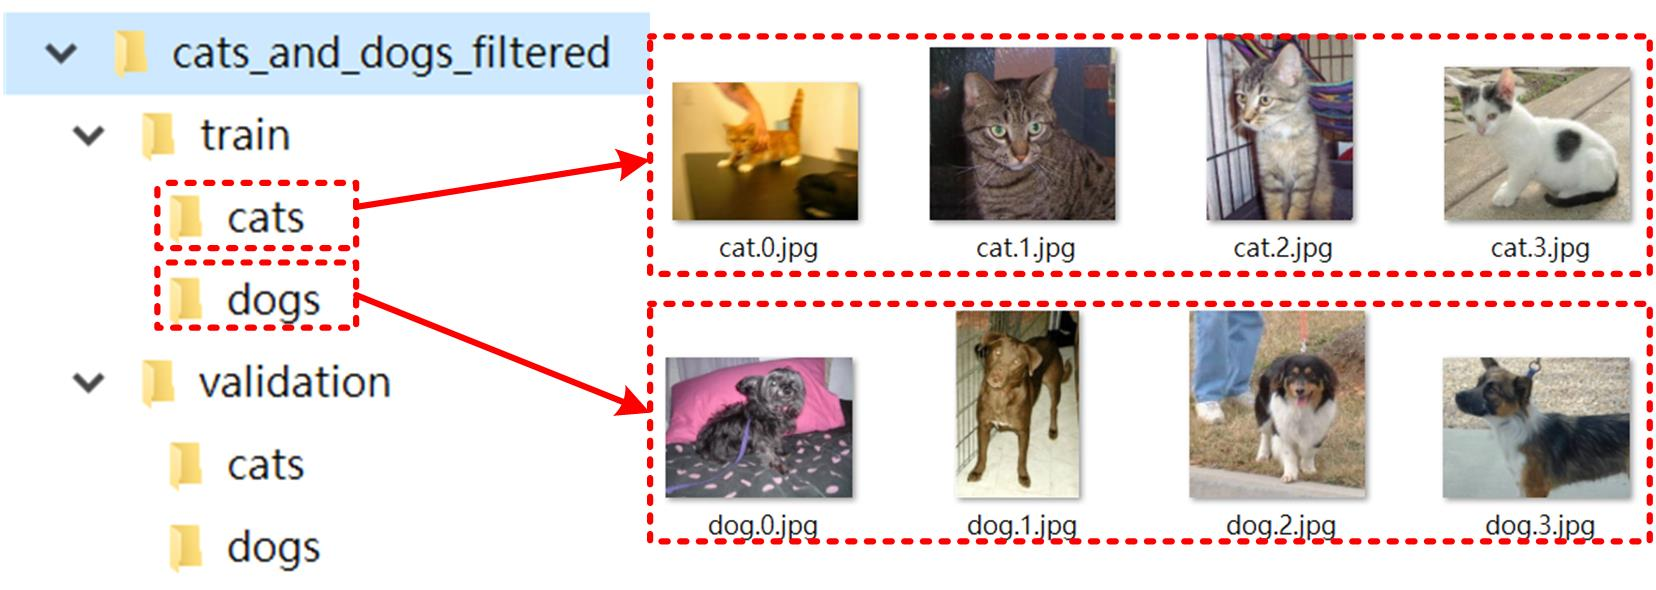

In [4]:
!mkdir /content/dataset # 建立/dataset路徑
!mkdir /content/dataset/cats_and_dogs_filtered
!cp /content/gdrive/MyDrive/test/cats_and_dogs_filtered.zip /content/dataset # 複製資料集檔案(*.zip)到虛擬機
!unzip /content/dataset/cats_and_dogs_filtered.zip -d /content/dataset # 解壓縮資料集
!ls /content/dataset # 列出資料集路徑清單

Archive:  /content/dataset/cats_and_dogs_filtered.zip
  inflating: /content/dataset/cats_and_dogs_filtered/vectorize.py  
   creating: /content/dataset/cats_and_dogs_filtered/validation/
   creating: /content/dataset/cats_and_dogs_filtered/train/
   creating: /content/dataset/cats_and_dogs_filtered/validation/dogs/
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: /content/dataset/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating

# **取得資料集路徑**

包含基礎、訓練及驗證資料集路徑名稱。

In [5]:
import os

# 取得資料集路徑
base_dir = '/content/dataset/cats_and_dogs_filtered'  # 取得資料集的基礎路徑名稱
train_dir = os.path.join(base_dir, 'train')           # 取得訓練資料集的路徑名稱
validation_dir = os.path.join(base_dir, 'validation') # 取得驗證資料集的路徑名稱

train_cats_dir = os.path.join(train_dir, 'cats')           # 取得訓練用貓圖片的路徑
train_dogs_dir = os.path.join(train_dir, 'dogs')           # 取得訓練用狗圖片的路徑
validation_cats_dir = os.path.join(validation_dir, 'cats') # 取得驗證用貓圖片的路徑
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 取得驗證用狗圖片的路徑

train_cat_fnames = os.listdir(train_cats_dir)              # 取得訓練用所有貓圖片名稱
train_dog_fnames = os.listdir(train_dogs_dir)              # 取得訓練用所有狗圖片名稱
validation_cat_fnames = os.listdir(validation_cats_dir)    # 取得驗證用所有貓圖片名稱
validation_dog_fnames = os.listdir(validation_dogs_dir)    # 取得驗用所有狗圖片名稱

# **列出資料集影像部份影像**

僅方便檢查用，這段程式可忽略，不用執行。

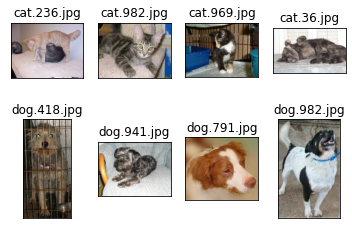

In [6]:
import matplotlib.pyplot as plt # 導入matplotlib繪圖相關函式
import matplotlib.image as mpimg # 導入matplotlib影像處理相闗函式

# 設定顯示圖像內容，貓狗各4張
cat_pic = [os.path.join(train_cats_dir, fname) 
             for fname in train_cat_fnames[:4]]
dog_pic = [os.path.join(train_dogs_dir, fname) 
             for fname in train_dog_fnames[:4]]

# 將取得圖像內容繪製至容器中
for i, img_path in enumerate(cat_pic+dog_pic):
  plt.subplot(2, 4, i + 1)
  plt.xticks([]), plt.yticks([]) # 取消X,Y軸標示及格線
  plt.title(os.path.basename(img_path)) # 將檔名加到標題
  img = mpimg.imread(img_path) # 讀取指定影像
  plt.imshow(img) # 顯示子圖

# 顯示最後結果
plt.show()

# **製作PyTorch格式資料集**

通常可使用一張影像一個標籤或者一個路徑共用一個標籤，本範例選擇後者。

為了使輸入資料格式能統一，這裡利用torchvision的轉換函式將影像強制縮放到224x224像素，且將數值從0~255正規化至-1~+1範圍，最後使用ImageFolder函式建立PyTorch格式的訓練資料集。

torchvision 提供許多現成的資料集、轉換（資料擴增）方法及深度學習模型。
可參考 https://pytorch.org/docs/stable/torchvision/index.html

In [7]:
import torch # 導入PyTorch函式庫
import torch as nn # 導入PyTorch函式庫
import torch.optim as optim # 導入PyTorch優化器相關函式
from torchvision import datasets, transforms, models # 導入torchvision中資料集、轉換及模型相關函數

train_transforms = transforms.Compose([transforms.Resize((224,224)), # 將輸入影像強制縮放至224x224像素
                                       #transforms.RandomResizedCrop(224), # 輸入影像隨機截切並縮放至224x224像素
                                       #transforms.RandomHorizontalFlip(), # 輸人影像隨機水平翻轉
                                       transforms.ToTensor(), # 建立張量
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # 使資料正規化到 -1 ~ +1
                                      ])
train_data = datasets.ImageFolder(train_dir, transform=train_transforms) # 建立PyTorch格式訓練資料集

print('Label: ', train_data.class_to_idx) # 將貓和狗的標籤（類別）轉成0和1
print('Image Path: ', train_data.imgs[0]) # 列出訓練資料集中第一張影像名稱及標籤
print(train_data[0][0]) # 列出訓練資料集中第一張影像的原始數據
print(train_data[0][1]) # 列出訓練資料集中第一張影像的標籤

for i in range(5):
  print('Image Size: ', train_data[i][0].shape) # 列出訓練資料集中前五張的資料（維度）大小

Label:  {'cats': 0, 'dogs': 1}
Image Path:  ('/content/dataset/cats_and_dogs_filtered/train/cats/cat.0.jpg', 0)
tensor([[[ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8902,  0.8745],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.8980,  0.8824],
         [ 0.5922,  0.6078,  0.6392,  ...,  0.9216,  0.9059,  0.8902],
         ...,
         [ 0.2078,  0.2157,  0.2235,  ..., -0.9765, -0.9765, -0.9765],
         [ 0.2000,  0.2000,  0.2078,  ..., -0.9843, -0.9843, -0.9843],
         [ 0.1843,  0.1922,  0.2000,  ..., -0.9922, -0.9922, -0.9922]],

        [[ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5843,  0.5686],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.5922,  0.5765],
         [ 0.2863,  0.3020,  0.3333,  ...,  0.6000,  0.6000,  0.5843],
         ...,
         [-0.0353, -0.0275, -0.0196,  ..., -0.9765, -0.9765, -0.9765],
         [-0.0431, -0.0431, -0.0353,  ..., -0.9843, -0.9843, -0.9843],
         [-0.0588, -0.0510, -0.0431,  ..., -0.9922, -0.9922, -0.9922]],

    

# **使用DataLoader隨機取出批次資料**

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

for i, (data, label) in enumerate(train_loader):
  if i<5 :
    print(f'[{i+1}] {data.shape}, {label}')
  else:
    break

[1] torch.Size([16, 3, 224, 224]), tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])
[2] torch.Size([16, 3, 224, 224]), tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
[3] torch.Size([16, 3, 224, 224]), tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])
[4] torch.Size([16, 3, 224, 224]), tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1])
[5] torch.Size([16, 3, 224, 224]), tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0])


# **建立卷積神經網路**



In [9]:
import torch # 導入PyTorch函式庫
import torch.nn as nn # 導入PyTorch函式庫
import torch.nn.functional as F #導入神經網路相關函式庫

class CNN(nn.Module): # 建立CNN類別函式
    def __init__(self, batch ): # 函數初始化
        super(CNN, self).__init__()
        # 定義第一卷積及最大池化層
        self.conv_1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2)
        # 定義第二卷積及最大池化層
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2)
        # 定義第三卷積及最大池化層
        self.conv_3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2)
        #定義第一全連接層
        self.fc_1 = nn.Linear(128*(28*28) , 512)
        #定義第二全連接層
        self.fc_2 = nn.Linear(512, 2) # 重要，輸出2個類別
        
    def forward(self, x): # 正向推論函式
        
        out = self.maxpool_1(F.relu(self.conv_1(x))) # 執行第一卷積及池化層
        out = self.maxpool_2(F.relu(self.conv_2(out))) # 執行第二卷積及池化層
        out = self.maxpool_3(F.relu(self.conv_3(out))) # 執行第三卷積及池化層
        out = out.view(-1, self.num_flat_features(out)) # 執行平坦化
        out = F.relu(self.fc_1(out)) # 執行第一全連接層
        out = F.softmax(self.fc_2(out)) # 執行第二全連接層
        return out # 得到最後輸出並返回
    
    def num_flat_features(self, x): # 計算平坦化特徵數量
        size = x.size()[1:] # 求得資料集大小
        num_features = 1

        for s in size:
            num_features *= s # 求特徵數量

        return num_features # 返回特徵值數量  

測試模型並列出執行結果

In [10]:
batch_size = 16 
model = CNN(batch_size)
print(model)
test = torch.rand([batch_size,3,224,224])
print(model(test))

CNN(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=100352, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=2, bias=True)
)
tensor([[0.5148, 0.4852],
        [0.5142, 0.4858],
        [0.5144, 0.4856],
        [0.5158, 0.4842],
        [0.5165, 0.4835],
        [0.5136, 0.4864],
        [0.5143, 0.4857],
        [0.5143, 0.4857],
        [0.5147, 0.4853],
        [0.5165, 0.4835],
        [0.5139, 0.4861],
        [0.5147, 0.4853],
        [0.5141, 0.4859],
        [0.5150, 0.4850]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


# **開始訓練模型及權重**


In [11]:
import torch.optim as optim # 導入PyTorch優化器相關函式
import matplotlib.pyplot as plt # 導入matplotlib繪圖相關函式
import time # 導入計時相關函數

# 設定訓練基本參數
epochs = 5 # 訓練迭代次數（所有資料集跑完epochs次）
batchs = 32 # 批次取樣數量（一次取batchs張影像計算）
lr = 1e-4 # 學習率（可另設為變動式）
step = 0 # 步階次數
train_loss = [] # 訓練損失
test_loss = [] # 測試損失

# 設定裝置，預設以GPU（CUDA）執行，若無則採CPU計算
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 隨機讀取批量影像進行訓練，shuffle = True表啟動隨機取樣
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchs, shuffle=True)
# 以GPU（CUDA）產生模型
model = CNN(batchs).to('cuda')
# 選用交叉熵損失函數
loss_fn = nn.CrossEntropyLoss()
# 選用Adam優化器函式
opt = optim.Adam(model.parameters(), lr= lr)

start = time.time() # 開始計時
model.train() # 模型訓練

print('開始訓練')
for i in range(epochs+1): # 設定迭代次數
    
    print('迭代次數: {}\n'.format(i+1)) # 列出目前迭代次數
    training_loss = 0 # 初始損失設為零
    epoch_time = time.time() # 開始迭代時間
    
    for idx, (data, label) in enumerate(train_loader): # 讀取資料集
        
        data, label = data.to(device), label.to(device) # 將模型及標籤載入裝置
        
        step += 1 # 步階加一
        predict = model(data) # 產生預測結果
        loss = loss_fn( predict, label) # 計算預測損失
        
        training_loss += loss.item() # 累加損失

        opt.zero_grad() # 把優化器梯度歸零
        
        loss.backward() # 反向傳播
        
        opt.step() # 優化器步進
        
        if(idx==0 or idx%10==0): # 每執行十次，列出執行結果
            print('[{}/{}] [{:04}/{:4}] loss:{:.6f}'.format(i, epochs, idx, int(25000/16) ,loss.item()))
    
    train_loss.append(training_loss*batchs/len(train_loader.dataset)) # 添加訓練損失並列出
    print("[{}/{}] loss:{:8.6f} time:{}".format(i, epochs, train_loss[i], time.time()-epoch_time))

end = time.time() # 結束計時 
model.eval() # 將模型轉為評估模式 

print('Cost time:', end-start) # 列出所有工作時間


開始訓練
迭代次數: 1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[0/5] [0000/1562] loss:0.692660
[0/5] [0010/1562] loss:0.715290
[0/5] [0020/1562] loss:0.691330
[0/5] [0030/1562] loss:0.673254
[0/5] [0040/1562] loss:0.654133
[0/5] [0050/1562] loss:0.702095
[0/5] [0060/1562] loss:0.694010
[0/5] loss:0.690514 time:11.35259222984314
迭代次數: 2

[1/5] [0000/1562] loss:0.664729
[1/5] [0010/1562] loss:0.671498
[1/5] [0020/1562] loss:0.640658
[1/5] [0030/1562] loss:0.559083
[1/5] [0040/1562] loss:0.649664
[1/5] [0050/1562] loss:0.570811
[1/5] [0060/1562] loss:0.577209
[1/5] loss:0.639621 time:11.133099555969238
迭代次數: 3

[2/5] [0000/1562] loss:0.607608
[2/5] [0010/1562] loss:0.664042
[2/5] [0020/1562] loss:0.589512
[2/5] [0030/1562] loss:0.594048
[2/5] [0040/1562] loss:0.587485
[2/5] [0050/1562] loss:0.590858
[2/5] [0060/1562] loss:0.557538
[2/5] loss:0.592153 time:11.134868860244751
迭代次數: 4

[3/5] [0000/1562] loss:0.585979
[3/5] [0010/1562] loss:0.513494
[3/5] [0020/1562] loss:0.567008
[3/5] [0030/1562] loss:0.542302
[3/5] [0040/1562] loss:0.562301
[3/5] [005

# **繪製損失函數曲線**

從圖上可看出損失值越來越小，有訓練成功的趨勢。這部份視需要可略過不執行。

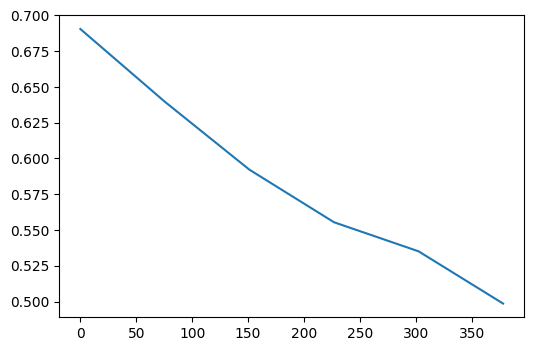

In [12]:
import numpy as np # 導人numpy數值計算函式

y = train_loss[:] # 設定Y軸為訓練損失值
x = np.linspace(0, step, len(y)) # 設定X軸為執行步階

plt.figure(dpi=100) # 設定繪圖解析度
plt.plot(x, y) # 繪圖
plt.show() # 顯示

# **進行推論**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[1.7030e-02, 9.8297e-01],
        [2.7469e-04, 9.9973e-01],
        [6.0163e-01, 3.9837e-01],
        [1.0871e-02, 9.8913e-01],
        [4.7737e-02, 9.5226e-01],
        [1.3384e-03, 9.9866e-01],
        [7.1166e-01, 2.8834e-01],
        [6.4615e-01, 3.5385e-01],
        [5.2073e-01, 4.7927e-01],
        [6.4303e-02, 9.3570e-01],
        [9.9770e-01, 2.2997e-03],
        [9.8905e-01, 1.0952e-02],
        [3.9794e-02, 9.6021e-01],
        [3.1748e-01, 6.8252e-01],
        [4.8842e-02, 9.5116e-01],
        [8.7058e-01, 1.2942e-01]], device='cuda:0')
tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')


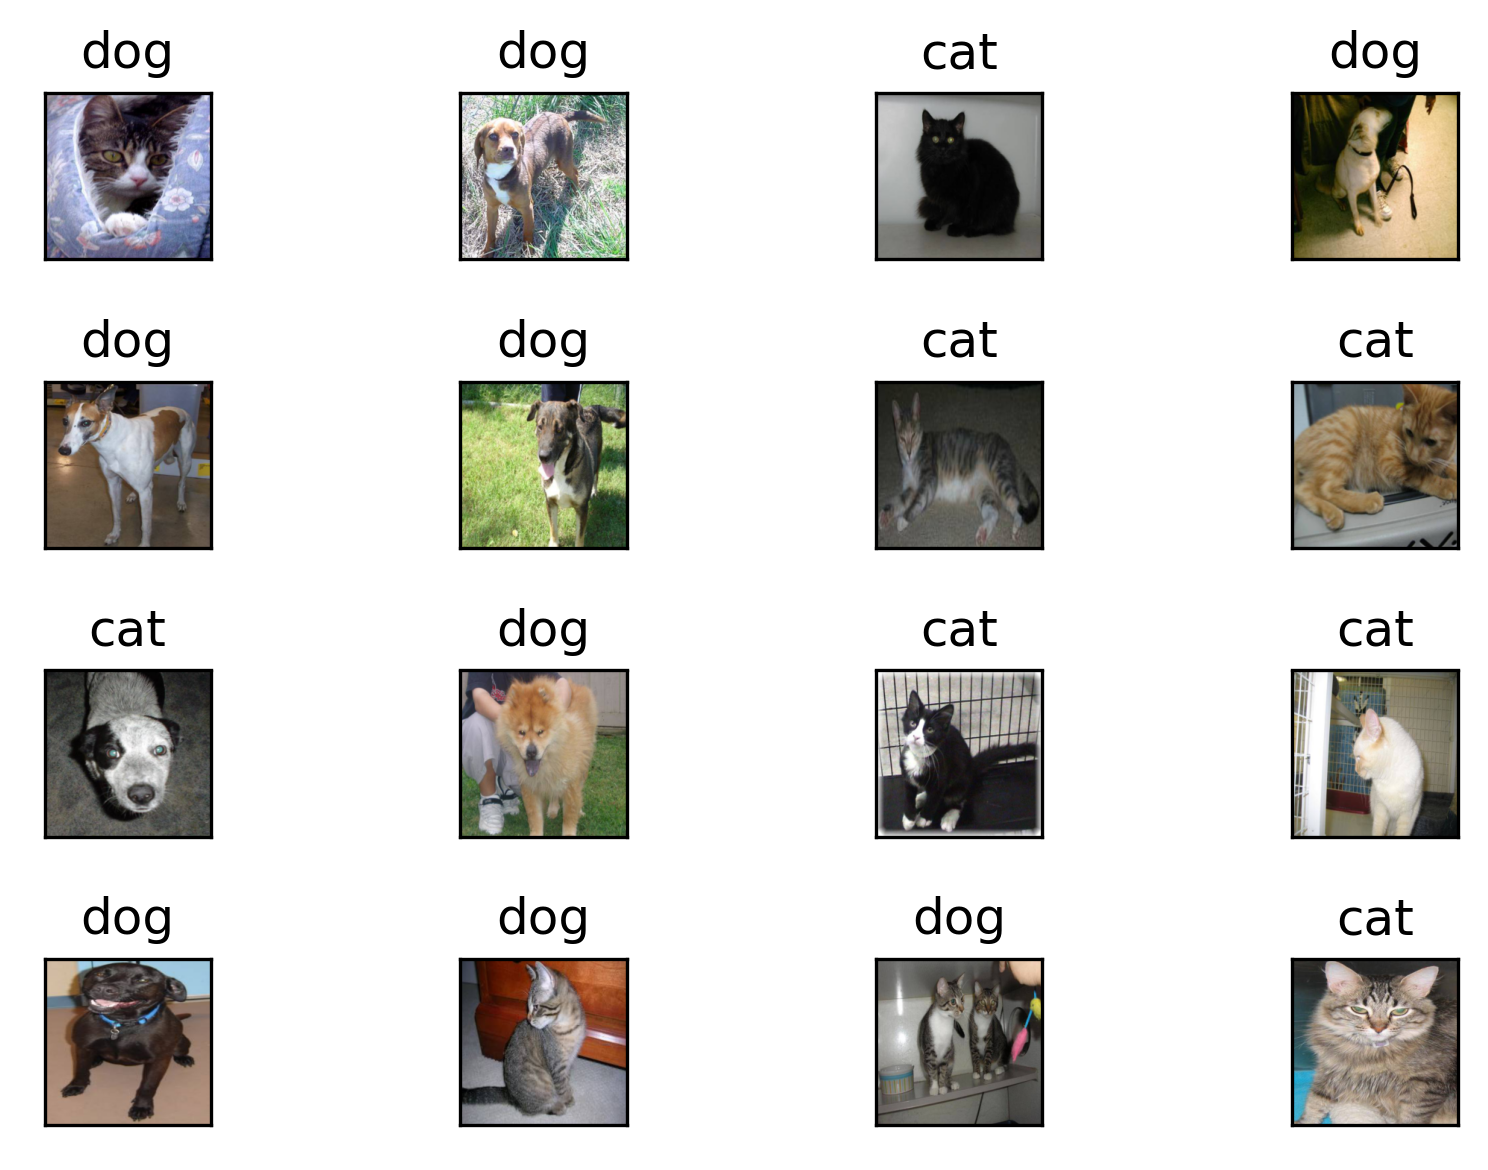

In [13]:
import torch # 導入PyTorch函式庫
import torch.nn as nn # 導入PyTorch函式庫
import torch.optim as optim # 導入PyTorch優化器函式庫
from torchvision import datasets, transforms, models # 導入torchvision資料集、轉換及模型函式
import matplotlib.pyplot as plt # 導入matplotlib繪函式庫

# 取得測試資料集路徑
base_dir = '/content/dataset/cats_and_dogs_filtered'
test_dir = os.path.join(base_dir, 'validation')

def cvt_img(im): # 影像轉換函式，把正規化數值轉回影像
    im = im.cpu().numpy().transpose((1, 2, 0)) # 資料轉置
    mean = np.array([0.5, ]) # 平均值
    std = np.array([0.5, ]) # 標準差
    im = std * im + mean # 將數值轉回影像
    #im = np.clip(im, 0, 1)
    return im # 返回影像

# 將資料轉換強制調整大小至224x224並將影像數值正規化
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

# 取得測試資料集並轉換
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
# 隨機取出batch_size張影像
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
# 設定繪製解析度
fig = plt.figure(dpi=300)

for idx, (data,_) in enumerate(test_loader): # 推論迴圈
    
    with torch.no_grad(): # 無梯度
    
        if idx>=1: break # 若標籤大於等於1則結束

        predict = model(data.to(device)) # 資料載入裝置並產生預測結果
        
        _, predicted = torch.max(predict, 1) # 找出輸出值最大的項目
        
        print(predict) # 列出預測結果數值
        print(predicted) # 列出預測結果項目 
        
        for i in range(16): # 繪製16張影像推論結果
            plt.subplot(4,4,i+1) # 設定子圖繪製位置
            plt.xticks([]), plt.yticks([]) # XY軸不繪刻度
            plt.title('cat' if predicted[i].cpu().numpy()==0 else 'dog') # 若預測結果為零則表示為貓否則為狗
            plt.imshow(cvt_img(data[i])) # 繪製已轉換回影像的資料

plt.tight_layout() # 緊密排版繪製
plt.show() # 顯示結果